<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

# grn bench perturb seq


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_perturb_gt

from bengrn.base import train_classifier

from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils

import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  IntOrKey = Union[int, jax.random.KeyArray]


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def validate_seed(seed: IntOrKey) -> jax.random.KeyArray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:21: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_random(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/utils/_kmeans.py:31: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def _initialize_plus_plus(X: jnp.ndarray, n_clusters: int, key: jax.random.KeyArray) -> jnp.ndarray:


In [2]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()
metrics = {}

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gem_group' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gene' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene_id' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gene_id' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/transcript' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/transcript' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/gene_transcript' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/gene_transcript' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/sgID_AB' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/sgID_AB' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/mitopercent' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/UMI_count' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/z_gemgroup_UMI' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/core_scale_factor' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/core_adjusted_UMI_count' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/cell_barcode' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/__categories/gene_name' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/gene_name' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/__categories/chr' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/chr' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/start' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/end' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/__categories/class' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/class' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/__categories/strand' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/strand' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/length' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/in_matrix' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/mean' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/std' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/cv' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/fano' was written without encoding metadata.
  return func(*args, **kwargs)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/var/gene_id' was written without encoding metadata.
  return func(*args, **kwargs)


650

In [3]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
adata

Dropping layers: 

KeysView(Layers with keys: )

checking raw counts

removed 0 non primary cells, 10691 renamining

filtered out 0 cells, 10691 renamining

Removed 8 genes.

startin QC

Seeing 10068 outliers (94.17% of total dataset):

done

GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [4]:
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)
#    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)
#    '../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000
NUM_CELLS = 1024
metrics = {}

RuntimeError caught: scPrint is not attached to a `Trainer`.

In [5]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=NUM_GENES,
                     max_cells=NUM_CELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp['all'] = grn.varp["GRN"]

/tmp/ipykernel_299123/2255780205.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],


Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8555

/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

precision: 

0.02072508763433421


recall: 

1.0


random precision:

0.02072944989230818

  0%|                         | 0/128 [00:00<?, ?it/s]

  2%|▎                | 2/128 [00:00<00:09, 12.64it/s]

  3%|▌                | 4/128 [00:00<00:10, 12.18it/s]

  5%|▊                | 6/128 [00:00<00:08, 13.65it/s]

  6%|█                | 8/128 [00:00<00:08, 14.49it/s]

  8%|█▎              | 10/128 [00:00<00:07, 15.03it/s]

  9%|█▌              | 12/128 [00:00<00:07, 15.33it/s]

 11%|█▊              | 14/128 [00:00<00:07, 15.52it/s]

 12%|██              | 16/128 [00:01<00:07, 15.69it/s]

 14%|██▎             | 18/128 [00:01<00:06, 15.76it/s]

 16%|██▌             | 20/128 [00:01<00:06, 15.83it/s]

 17%|██▊             | 22/128 [00:01<00:06, 15.88it/s]

 19%|███             | 24/128 [00:01<00:06, 16.61it/s]

 21%|███▍            | 27/128 [00:01<00:05, 18.88it/s]

 23%|███▊            | 30/128 [00:01<00:04, 21.67it/s]

 26%|████▏           | 33/128 [00:01<00:03, 23.77it/s]

 28%|████▌           | 36/128 [00:01<00:03, 25.13it/s]

 30%|████▉           | 39/128 [00:02<00:03, 26.32it/s]

 33%|█████▎          | 42/128 [00:02<00:03, 21.87it/s]

 35%|█████▋          | 45/128 [00:02<00:03, 23.68it/s]

 38%|██████          | 48/128 [00:02<00:03, 25.13it/s]

 40%|██████▍         | 51/128 [00:02<00:02, 25.92it/s]

 42%|██████▊         | 54/128 [00:02<00:02, 26.10it/s]

 45%|███████▏        | 57/128 [00:02<00:02, 27.00it/s]

 47%|███████▌        | 60/128 [00:02<00:02, 27.63it/s]

 49%|███████▉        | 63/128 [00:03<00:02, 27.99it/s]

 52%|████████▎       | 66/128 [00:03<00:02, 28.40it/s]

 54%|████████▋       | 69/128 [00:03<00:02, 28.58it/s]

 56%|█████████       | 72/128 [00:03<00:01, 28.82it/s]

 59%|█████████▍      | 75/128 [00:03<00:01, 28.88it/s]

 61%|█████████▊      | 78/128 [00:03<00:01, 28.98it/s]

 63%|██████████▏     | 81/128 [00:03<00:01, 28.80it/s]

 66%|██████████▌     | 84/128 [00:03<00:01, 28.84it/s]

 68%|██████████▉     | 87/128 [00:03<00:01, 28.82it/s]

 70%|███████████▎    | 90/128 [00:04<00:01, 23.20it/s]

 73%|███████████▋    | 93/128 [00:04<00:01, 21.20it/s]

 75%|████████████    | 96/128 [00:04<00:01, 22.01it/s]

 77%|████████████▍   | 99/128 [00:04<00:01, 23.76it/s]

 80%|███████████▉   | 102/128 [00:04<00:01, 25.21it/s]

 82%|████████████▎  | 105/128 [00:04<00:00, 26.32it/s]

 84%|████████████▋  | 108/128 [00:04<00:00, 27.16it/s]

 87%|█████████████  | 111/128 [00:04<00:00, 27.76it/s]

 89%|█████████████▎ | 114/128 [00:04<00:00, 28.12it/s]

 91%|█████████████▋ | 117/128 [00:05<00:00, 28.43it/s]

 94%|██████████████ | 120/128 [00:05<00:00, 28.56it/s]

 96%|██████████████▍| 123/128 [00:05<00:00, 28.62it/s]

 98%|██████████████▊| 126/128 [00:05<00:00, 28.74it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████| 128/128 [00:05<00:00, 23.00it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0306460912876219

EPR:

2.7145869362980646

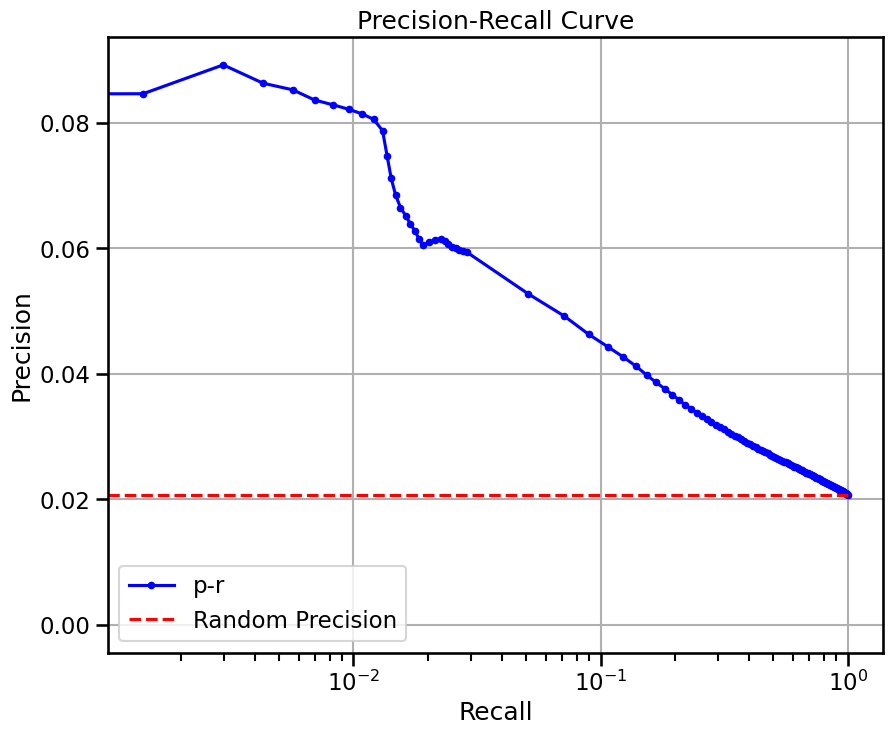

In [6]:
grn.varp['GRN'] = grn.varp["all"].mean(-1).T
metrics['scprint_mean_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [7]:
grn.var

,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,...,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,TFs
ENSG00000000457,SCYL3,chr1,169849631.0,169894267.0,gene_version14,-,44636.0,True,0.130889,0.367093,...,0.117003,88.551118,1327.0,7.191429,True,4421.0,0.124123,0.129307,0.977926,False
ENSG00000000460,C1orf112,chr1,169662007.0,169854080.0,gene_version17,+,192073.0,True,0.389123,0.656317,...,0.344100,67.393134,4391.0,8.387540,True,4880.0,0.410719,0.442426,0.973713,False
ENSG00000001036,FUCA2,chr6,143494812.0,143511720.0,gene_version14,-,16908.0,True,0.989478,1.101708,...,0.698185,39.304088,10799.0,9.287301,True,4230.0,1.010102,1.211872,0.979566,False
ENSG00000001167,NFYA,chr6,41072945.0,41099976.0,gene_version14,+,27031.0,True,0.123743,0.361088,...,0.121818,88.130203,1385.0,7.234177,True,2925.0,0.129548,0.136349,0.993233,True
ENSG00000001461,NIPAL3,chr1,24415802.0,24472976.0,gene_version17,+,57174.0,True,0.133647,0.374701,...,0.118749,88.438874,1348.0,7.207119,True,3361.0,0.126087,0.132463,0.988278,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284753,EEF1AKMT4,chr3,184249650.0,184259585.0,gene_version1,+,9935.0,True,0.412459,0.692414,...,0.370340,65.615939,4792.0,8.474912,True,1460.0,0.448227,0.510392,1.021537,False
ENSG00000284976,BX255925.3,chr9,137217452.0,137219361.0,gene_version1,+,1909.0,True,0.139813,0.381638,...,0.123142,87.971191,1401.0,7.245655,True,3651.0,0.131045,0.136708,0.985556,False
ENSG00000285053,TBCE,chr1,235328570.0,235448952.0,gene_version1,+,120382.0,True,0.150584,0.397857,...,0.141172,86.128519,1621.0,7.391415,True,4370.0,0.151623,0.156709,0.978370,False
ENSG00000285437,POLR2J3,chr7,102562133.0,102572583.0,gene_version1,-,10450.0,True,2.389258,2.049748,...,1.199370,15.686091,24782.0,10.117913,True,758.0,2.318025,3.630002,1.066965,False


base enrichment

Top central genes:

[]

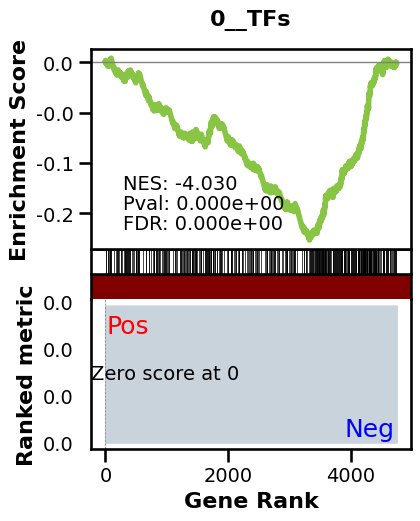

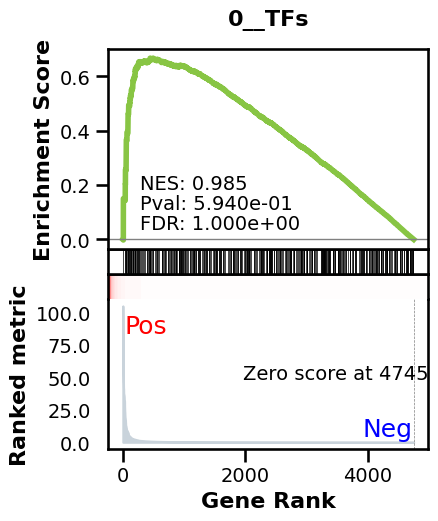

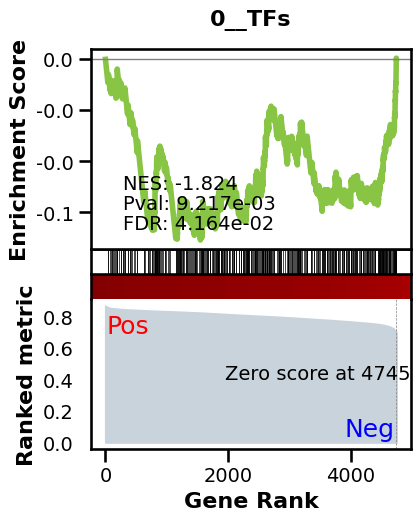

_________________________________________

TF specific enrichment

found some significant results for 

8.620689655172415

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3317 genes

intersection pct:

0.6980218855218855

precision: 

0.001612544216131459


recall: 

1.0


random precision:

0.0016130305081146108

  0%|                         | 0/128 [00:00<?, ?it/s]

  5%|▊                | 6/128 [00:00<00:02, 58.51it/s]

  9%|█▌              | 12/128 [00:00<00:01, 58.90it/s]

 14%|██▎             | 18/128 [00:00<00:01, 59.24it/s]

 19%|███             | 24/128 [00:00<00:01, 59.19it/s]

 23%|███▊            | 30/128 [00:00<00:01, 59.27it/s]

 28%|████▌           | 36/128 [00:00<00:01, 59.45it/s]

 33%|█████▎          | 42/128 [00:00<00:01, 59.34it/s]

 38%|██████          | 48/128 [00:00<00:01, 59.43it/s]

 42%|██████▊         | 54/128 [00:00<00:01, 59.27it/s]

 47%|███████▌        | 60/128 [00:01<00:01, 59.36it/s]

 52%|████████▎       | 66/128 [00:01<00:01, 59.37it/s]

 56%|█████████       | 72/128 [00:01<00:00, 59.19it/s]

 61%|█████████▊      | 78/128 [00:01<00:00, 59.34it/s]

 66%|██████████▌     | 84/128 [00:01<00:00, 59.20it/s]

 70%|███████████▎    | 90/128 [00:01<00:00, 59.43it/s]

 75%|████████████    | 96/128 [00:01<00:00, 59.53it/s]

 80%|███████████▉   | 102/128 [00:01<00:00, 59.34it/s]

 84%|████████████▋  | 108/128 [00:01<00:00, 59.39it/s]

 89%|█████████████▎ | 114/128 [00:01<00:00, 59.40it/s]

 94%|██████████████ | 120/128 [00:02<00:00, 59.33it/s]

 98%|██████████████▊| 126/128 [00:02<00:00, 59.36it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████| 128/128 [00:02<00:00, 59.21it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.0014320080060727762

EPR:

1.5753304315932883

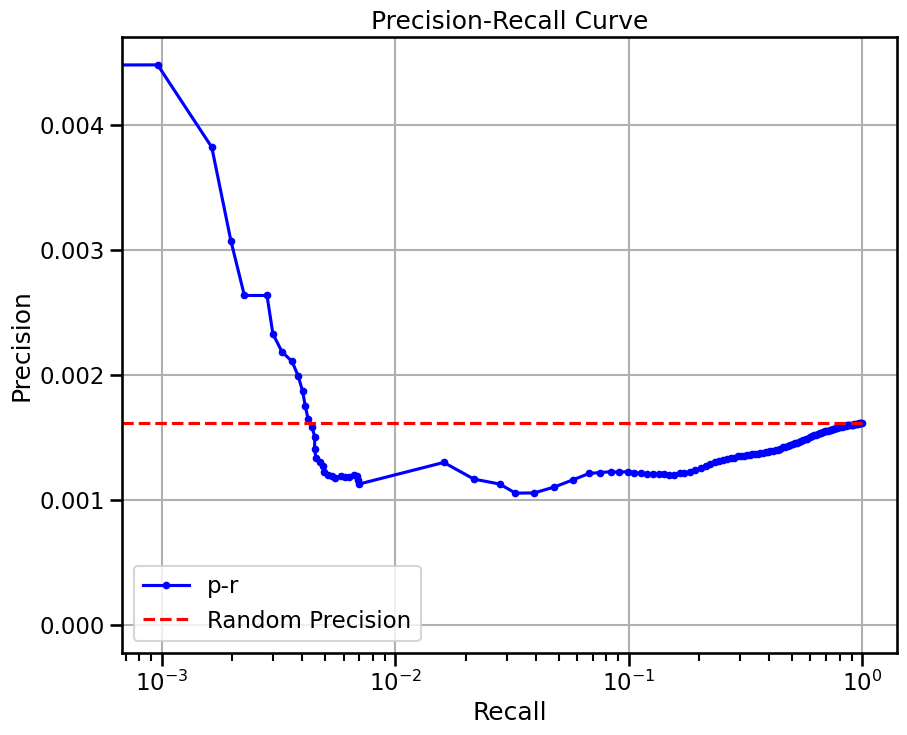

In [8]:
grn.var['ensembl_id'] = grn.var.index
grn.var.index = grn.var['symbol']
metrics['scprint_mean_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

true elem

17394

...

doing classification....

metrics

{'used_heads': 105, 'precision': 0.004637297118251077, 'random_precision': 0.001610562441384053, 'recall': 0.008144269924374637, 'predicted_true': 3019.0, 'number_of_true': 1719.0, 'epr': 3.2745460141582026}

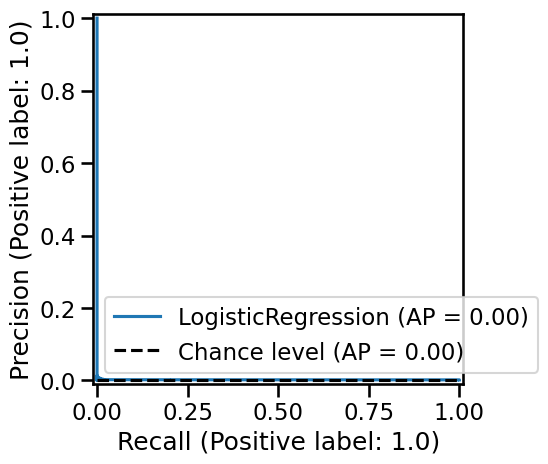

precision: 

0.02072508763433421


recall: 

1.0


random precision:

0.02072944989230818

  0%|                         | 0/128 [00:00<?, ?it/s]

  1%|▏                | 1/128 [00:00<00:12,  9.86it/s]

  2%|▍                | 3/128 [00:00<00:10, 11.94it/s]

  4%|▋                | 5/128 [00:00<00:09, 12.68it/s]

  5%|▉                | 7/128 [00:00<00:09, 12.98it/s]

  7%|█▏               | 9/128 [00:00<00:08, 13.31it/s]

  9%|█▍              | 11/128 [00:00<00:08, 13.48it/s]

 10%|█▋              | 13/128 [00:00<00:08, 13.52it/s]

 12%|█▉              | 15/128 [00:01<00:08, 13.70it/s]

 13%|██▏             | 17/128 [00:01<00:08, 13.83it/s]

 15%|██▍             | 19/128 [00:01<00:07, 13.88it/s]

 16%|██▋             | 21/128 [00:01<00:07, 14.36it/s]

 19%|███             | 24/128 [00:01<00:06, 16.60it/s]

 21%|███▍            | 27/128 [00:01<00:05, 18.14it/s]

 23%|███▊            | 30/128 [00:01<00:05, 19.06it/s]

 26%|████▏           | 33/128 [00:02<00:04, 19.85it/s]

 27%|████▍           | 35/128 [00:02<00:04, 19.79it/s]

 30%|████▊           | 38/128 [00:02<00:04, 20.28it/s]

 32%|█████▏          | 41/128 [00:02<00:04, 20.68it/s]

 34%|█████▌          | 44/128 [00:02<00:04, 20.82it/s]

 37%|█████▉          | 47/128 [00:02<00:03, 21.09it/s]

 39%|██████▎         | 50/128 [00:02<00:03, 21.30it/s]

 41%|██████▋         | 53/128 [00:03<00:03, 21.44it/s]

 44%|███████         | 56/128 [00:03<00:03, 21.35it/s]

 46%|███████▍        | 59/128 [00:03<00:03, 21.29it/s]

 48%|███████▊        | 62/128 [00:03<00:03, 21.42it/s]

 51%|████████▏       | 65/128 [00:03<00:02, 21.38it/s]

 53%|████████▌       | 68/128 [00:03<00:02, 21.46it/s]

 55%|████████▉       | 71/128 [00:03<00:02, 21.50it/s]

 58%|█████████▎      | 74/128 [00:04<00:02, 21.49it/s]

 60%|█████████▋      | 77/128 [00:04<00:02, 21.56it/s]

 62%|██████████      | 80/128 [00:04<00:02, 21.57it/s]

 65%|██████████▍     | 83/128 [00:04<00:02, 21.52it/s]

 67%|██████████▊     | 86/128 [00:04<00:01, 21.54it/s]

 70%|███████████▏    | 89/128 [00:04<00:01, 21.51it/s]

 72%|███████████▌    | 92/128 [00:04<00:01, 21.50it/s]

 74%|███████████▉    | 95/128 [00:04<00:01, 21.33it/s]

 77%|████████████▎   | 98/128 [00:05<00:01, 21.51it/s]

 79%|███████████▊   | 101/128 [00:05<00:01, 21.54it/s]

 81%|████████████▏  | 104/128 [00:05<00:01, 21.51it/s]

 84%|████████████▌  | 107/128 [00:05<00:00, 21.53it/s]

 86%|████████████▉  | 110/128 [00:05<00:00, 21.55it/s]

 88%|█████████████▏ | 113/128 [00:05<00:00, 21.61it/s]

 91%|█████████████▌ | 116/128 [00:05<00:00, 21.65it/s]

 93%|█████████████▉ | 119/128 [00:06<00:00, 21.62it/s]

 95%|██████████████▎| 122/128 [00:06<00:00, 21.67it/s]

 98%|██████████████▋| 125/128 [00:06<00:00, 21.26it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████| 128/128 [00:06<00:00, 18.97it/s]

100%|███████████████| 128/128 [00:06<00:00, 19.42it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.02076648183802014

EPR:

0.7488938507236744

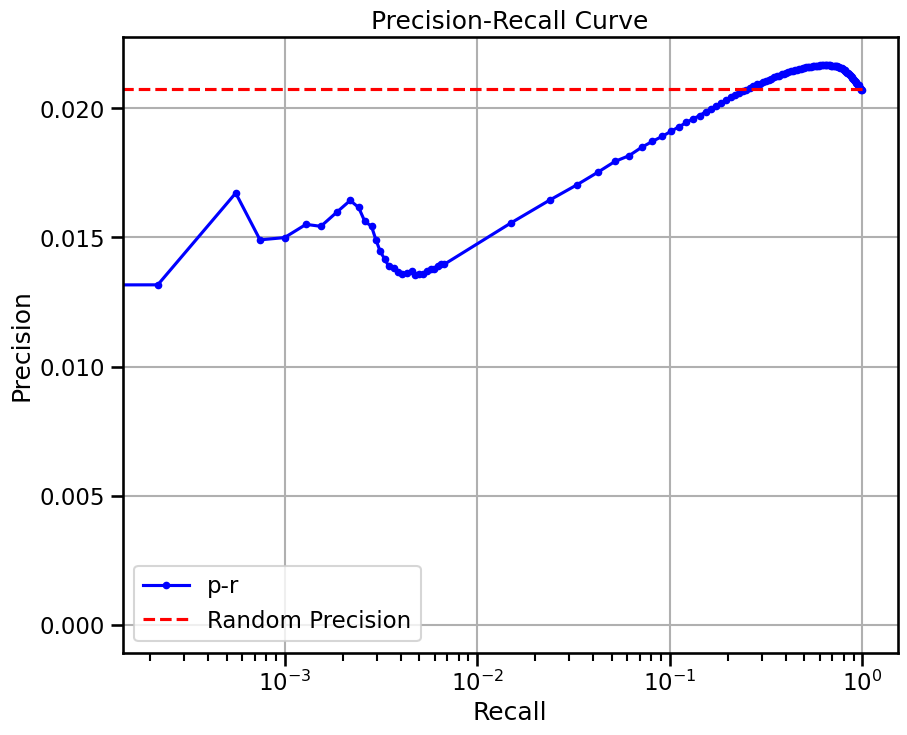

In [9]:
grn.varp['GRN'] = grn.varp["all"]
grn.var.index = grn.var['ensembl_id']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True, use_col="gene_name")
grn.varp['GRN'] = grn.varp['classified']

metrics['scprint_omni_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)


base enrichment

Top central genes:

[]

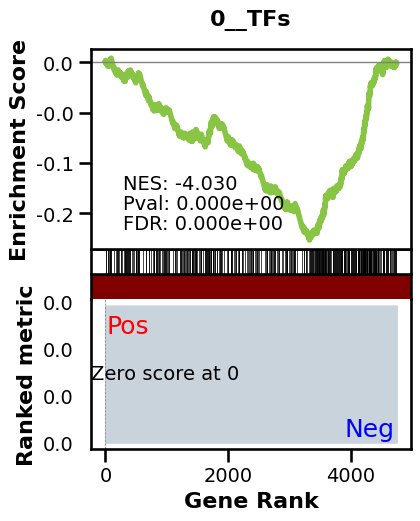

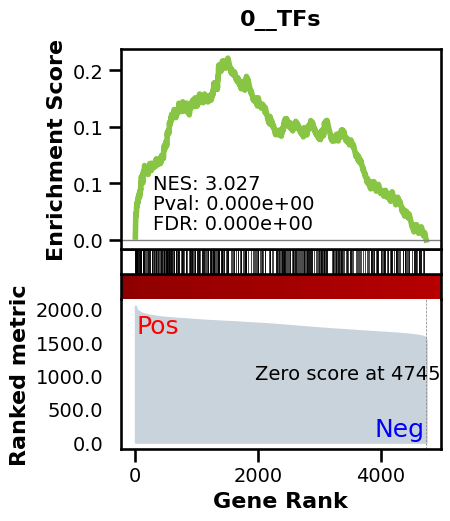

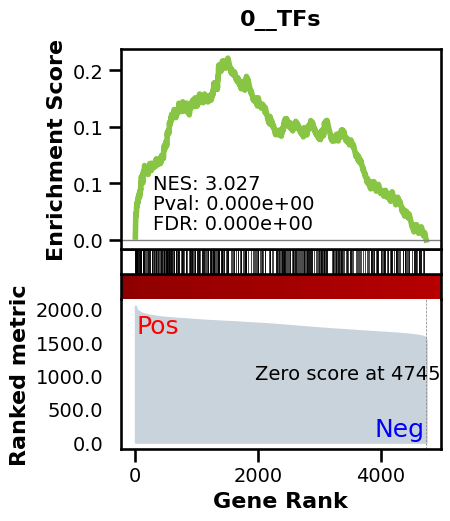

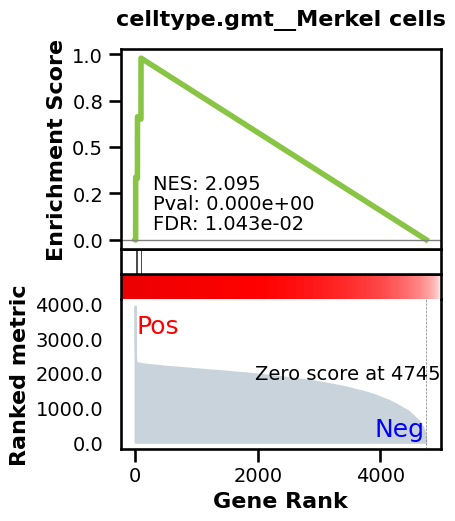

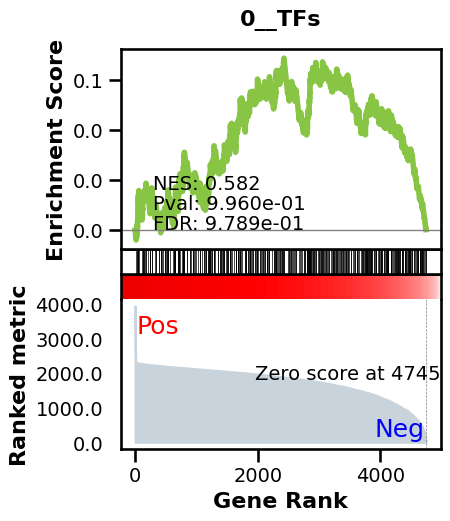

_________________________________________

TF specific enrichment

found some significant results for 

3.4482758620689653

% TFs


_________________________________________

loading GT, 

omnipath

intersection of 3317 genes

intersection pct:

0.6980218855218855

precision: 

0.001612544216131459


recall: 

1.0


random precision:

0.0016130305081146108

  0%|                         | 0/128 [00:00<?, ?it/s]

  5%|▊                | 6/128 [00:00<00:02, 50.50it/s]

  9%|█▌              | 12/128 [00:00<00:02, 50.54it/s]

 14%|██▎             | 18/128 [00:00<00:02, 50.65it/s]

 19%|███             | 24/128 [00:00<00:02, 50.75it/s]

 23%|███▊            | 30/128 [00:00<00:01, 50.83it/s]

 28%|████▌           | 36/128 [00:00<00:01, 50.83it/s]

 33%|█████▎          | 42/128 [00:00<00:01, 50.78it/s]

 38%|██████          | 48/128 [00:00<00:01, 50.93it/s]

 42%|██████▊         | 54/128 [00:01<00:01, 50.97it/s]

 47%|███████▌        | 60/128 [00:01<00:01, 51.05it/s]

 52%|████████▎       | 66/128 [00:01<00:01, 51.12it/s]

 56%|█████████       | 72/128 [00:01<00:01, 51.13it/s]

 61%|█████████▊      | 78/128 [00:01<00:00, 51.02it/s]

 66%|██████████▌     | 84/128 [00:01<00:00, 51.09it/s]

 70%|███████████▎    | 90/128 [00:01<00:00, 50.51it/s]

 75%|████████████    | 96/128 [00:01<00:00, 50.63it/s]

 80%|███████████▉   | 102/128 [00:02<00:00, 50.62it/s]

 84%|████████████▋  | 108/128 [00:02<00:00, 50.80it/s]

 89%|█████████████▎ | 114/128 [00:02<00:00, 50.91it/s]

 94%|██████████████ | 120/128 [00:02<00:00, 51.01it/s]

 98%|██████████████▊| 126/128 [00:02<00:00, 51.05it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████| 128/128 [00:02<00:00, 50.83it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.001893502679383507

EPR:

4.702666604157438

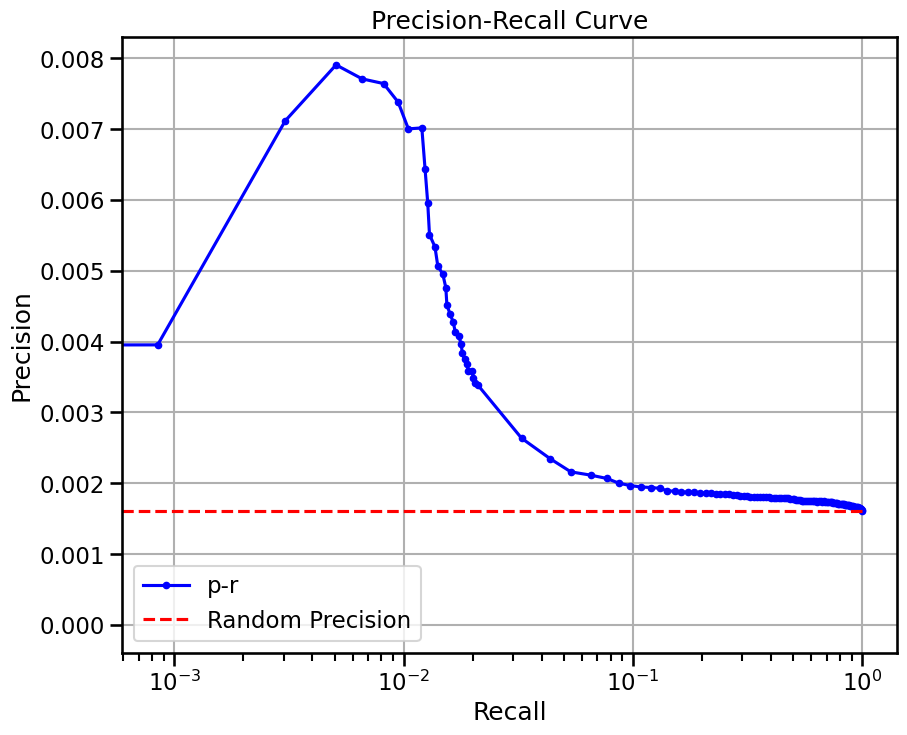

In [10]:
grn.var.index = grn.var['symbol']
metrics['scprint_omni_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

pred shape

(2920, 4752, 128)

true elem

287578

...

doing classification....

metrics

{'used_heads': 121, 'precision': 0.06304139899242187, 'random_precision': 0.02150860776716941, 'recall': 0.2181940023454515, 'predicted_true': 516486, 'number_of_true': 149225, 'epr': 5.035195966522557}

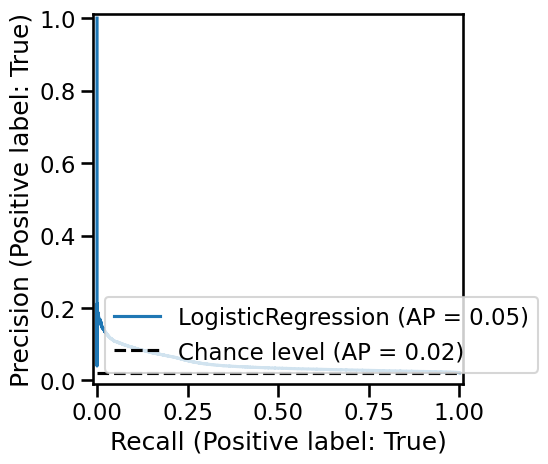

In [11]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(grn, other=adata, C=0.8, train_size=0.5, class_weight={
                               1: 30, 0: 1}, shuffle=False, use_col="ensembl_id")
grn.varp['GRN'] = grn.varp['classified']

precision: 

0.02072508763433421


recall: 

1.0


random precision:

0.02072944989230818

  0%|                         | 0/128 [00:00<?, ?it/s]

  2%|▎                | 2/128 [00:00<00:10, 12.50it/s]

  3%|▌                | 4/128 [00:00<00:10, 11.32it/s]

  5%|▊                | 6/128 [00:00<00:10, 12.10it/s]

  6%|█                | 8/128 [00:00<00:09, 12.55it/s]

  8%|█▎              | 10/128 [00:00<00:09, 12.92it/s]

  9%|█▌              | 12/128 [00:00<00:08, 13.08it/s]

 11%|█▊              | 14/128 [00:01<00:08, 13.17it/s]

 12%|██              | 16/128 [00:01<00:08, 12.58it/s]

 14%|██▎             | 18/128 [00:01<00:08, 12.90it/s]

 16%|██▌             | 20/128 [00:01<00:08, 13.16it/s]

 17%|██▊             | 22/128 [00:01<00:07, 13.36it/s]

 19%|███             | 24/128 [00:01<00:07, 13.43it/s]

 20%|███▎            | 26/128 [00:02<00:07, 13.39it/s]

 22%|███▌            | 28/128 [00:02<00:07, 13.42it/s]

 23%|███▊            | 30/128 [00:02<00:07, 13.54it/s]

 25%|████            | 32/128 [00:02<00:06, 13.88it/s]

 27%|████▎           | 34/128 [00:02<00:06, 15.21it/s]

 29%|████▋           | 37/128 [00:02<00:05, 17.15it/s]

 31%|█████           | 40/128 [00:02<00:04, 18.56it/s]

 34%|█████▍          | 43/128 [00:02<00:04, 19.31it/s]

 36%|█████▊          | 46/128 [00:03<00:04, 19.94it/s]

 38%|██████▏         | 49/128 [00:03<00:03, 20.40it/s]

 41%|██████▌         | 52/128 [00:03<00:03, 20.69it/s]

 43%|██████▉         | 55/128 [00:03<00:04, 18.24it/s]

 45%|███████▎        | 58/128 [00:03<00:03, 19.08it/s]

 48%|███████▋        | 61/128 [00:03<00:03, 19.65it/s]

 50%|████████        | 64/128 [00:04<00:03, 20.20it/s]

 52%|████████▍       | 67/128 [00:04<00:02, 20.36it/s]

 55%|████████▊       | 70/128 [00:04<00:02, 20.68it/s]

 57%|█████████▏      | 73/128 [00:04<00:02, 20.77it/s]

 59%|█████████▌      | 76/128 [00:04<00:02, 20.92it/s]

 62%|█████████▉      | 79/128 [00:04<00:02, 21.01it/s]

 64%|██████████▎     | 82/128 [00:04<00:02, 21.18it/s]

 66%|██████████▋     | 85/128 [00:05<00:02, 20.93it/s]

 69%|███████████     | 88/128 [00:05<00:01, 21.07it/s]

 71%|███████████▍    | 91/128 [00:05<00:01, 20.83it/s]

 73%|███████████▊    | 94/128 [00:05<00:01, 20.36it/s]

 76%|████████████▏   | 97/128 [00:05<00:01, 19.96it/s]

 78%|███████████▋   | 100/128 [00:05<00:01, 19.80it/s]

 80%|███████████▉   | 102/128 [00:05<00:01, 19.71it/s]

 81%|████████████▏  | 104/128 [00:05<00:01, 19.56it/s]

 83%|████████████▍  | 106/128 [00:06<00:01, 19.47it/s]

 84%|████████████▋  | 108/128 [00:06<00:01, 19.50it/s]

 86%|████████████▉  | 110/128 [00:06<00:01, 16.34it/s]

 88%|█████████████▏ | 112/128 [00:06<00:01, 15.53it/s]

 89%|█████████████▎ | 114/128 [00:06<00:00, 15.00it/s]

 91%|█████████████▌ | 116/128 [00:06<00:00, 14.45it/s]

 92%|█████████████▊ | 118/128 [00:06<00:00, 14.17it/s]

 94%|██████████████ | 120/128 [00:07<00:00, 14.11it/s]

 95%|██████████████▎| 122/128 [00:07<00:00, 14.02it/s]

 97%|██████████████▌| 124/128 [00:07<00:00, 13.99it/s]

 98%|██████████████▊| 126/128 [00:07<00:00, 13.98it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()


100%|███████████████| 128/128 [00:07<00:00, 13.84it/s]

100%|███████████████| 128/128 [00:07<00:00, 16.71it/s]

Area Under Precision-Recall Curve (AUPRC): 

0.04312187463075986

EPR:

4.830323808971622

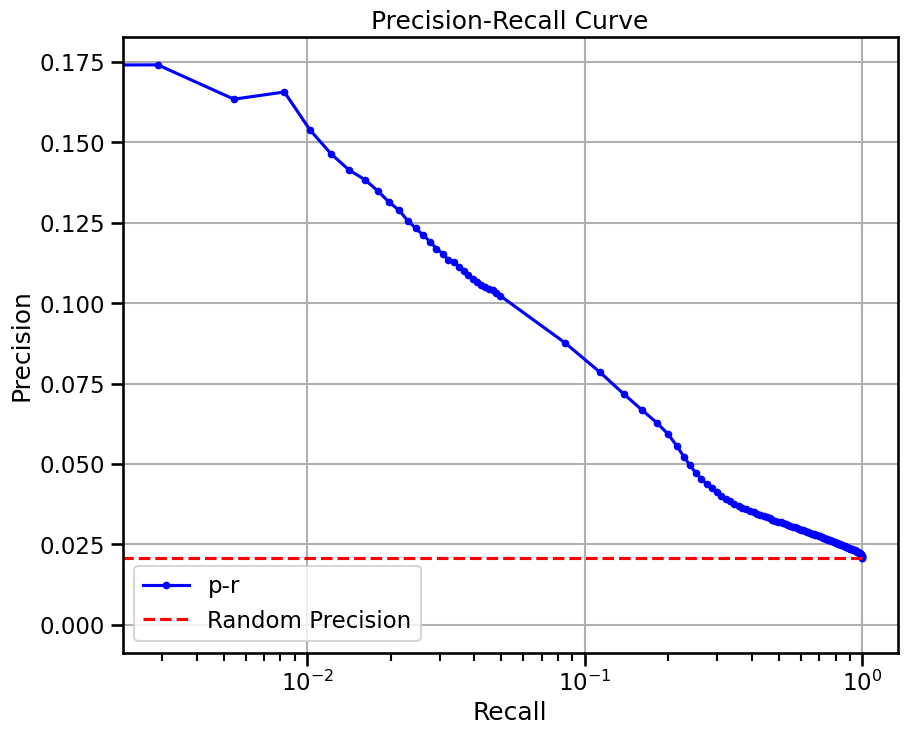

In [12]:
metrics['scprint_self_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
metrics['scprint_self_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

base enrichment

Top central genes:

[]

2024-06-27 16:47:10,606 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.



2024-06-27 16:47:10,610 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2D1A, CCDC169-SOHLH2, CCDC17, CDC5L, CDX1, CDX2, CDX4, CEBPA, CEBPB, CEBPD, CEBPE, CEBPG, CEBPZ, CENPA, CENPB, CENPBD1, CENPS, CENPT, CENPX, CGGBP1, CHAMP1, CHCHD3, CIC, CLOCK, CPEB1, CPXCR1, CREB1, CREB3, CREB3L1, CREB3L2, CREB3L3, CREB3L4, CREB5, CREBL2, CREBZF, CREM, CR

2024-06-27 16:47:10,615 [ERROR] The first 5 genes look like this : [ ENSG00000000457, ENSG00000004455, ENSG00000001167, ENSG00000001461, ENSG00000001629 ]


/home/ml4ig1/Documents code/GRnnData/grnndata/utils.py:318: DeprecationWarning: invalid escape sequence '\m'
  """


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [ ]:
grn_inferer = GRNfer(model, nadata[nadata.X.sum(1) > 500],
                     how="random_expr",
                     preprocess="softmax",
                     head_agg='mean',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     num_genes=3000,
                     max_cells=NUM_CELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
metrics["scprint_full_perturb"] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [ ]:
metrics